In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
!pip install shap
!pip install bayesian-optimization
!pip install lightgbm
!pip install imblearn

     |████████████████████████████████| 266kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383187 sha256=aed837767a06f20cd12a260f35bba7b2ced34ca921e32669b66c7004758ddd4d
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap


In [0]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

train = pd.read_csv('/gdrive/My Drive/Data/train.csv', index_col=0)
test = pd.read_csv('/gdrive/My Drive/Data/test.csv', index_col=0)
sample_submission = pd.read_csv('/gdrive/My Drive/Data/sample_submission.csv', index_col=0)
scaler = MinMaxScaler()

unique_labels = train["type"].unique()
label_dict = {val: i for i, val in enumerate(unique_labels)}
i2lb = {v:k for k, v in label_dict.items()}

column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train['type_num'] = train['type'].apply(lambda x: to_number(x, column_number))
train.drop("type",axis = 1,inplace=True)


train_yk = train[["type_num","fiberID"]]
train1 = train.drop(["type_num","fiberID"],axis=1)
feature_col = train1.columns
train_k = train1[train1[feature_col] < -2000]
train_k1 = train1[train1[feature_col] > 1000]
pre_index1 = set(train_k.dropna(how="all",axis=0).index)
pre_index2 = set(train_k1.dropna(how="all",axis=0).index)
pre_index = list(pre_index1|pre_index2)
train1 = train1.drop(pre_index,axis=0).reset_index(drop=True)
train_yk = train_yk.drop(pre_index,axis=0).reset_index(drop=True)
train = pd.concat([train_yk,train1[feature_col]],axis=1)

train = train.drop([93828,47032,133359,120394,120721,120339,35853],axis=0).reset_index(drop=True)

In [37]:
train2 = train[["fiberID","type_num"]]
train2["count"] =1
train2_g = train2.groupby(["fiberID","type_num"]).count().unstack("type_num")
train2_g.fillna(0,inplace=True)
train_value = train["type_num"].value_counts().sort_index()
for i in range(train2_g.shape[1]):
  train2_g.iloc[:,i] = train2_g.iloc[:,i]*100 / train_value[i]
train2_g.columns = sample_submission.columns
train2_g.reset_index(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
train = train.merge(train2_g,on="fiberID")
test = test.merge(train2_g,on="fiberID")
train_x = train.drop(['type_num','fiberID'], axis=1)
train_y = train['type_num']
test_x = test.drop('fiberID',axis=1)
sc_col = train_x.iloc[:,:20].columns
not_col = train_x.columns.difference(sc_col)
tr_ind =  train_x.index
te_ind = test_x.index

In [0]:
set_d = pd.concat([train_x[sc_col],test_x[sc_col]],axis=0)
set_data = pd.DataFrame(index = set_d.index)
set_data2 = pd.DataFrame(index = set_d.index)
set_data3 = pd.DataFrame(index = set_d.index)

for i in sc_col:
  set_data[i] = set_d[i]-set_d[i].min()+2
  set_data2["".join([i,"2"])] = set_data[i]**2/100
  set_data2["".join([i,"3"])] = set_data[i]**3/10000
set_data = pd.concat([set_data,set_data2],axis=1)

In [8]:
set_data.shape

(209962, 60)

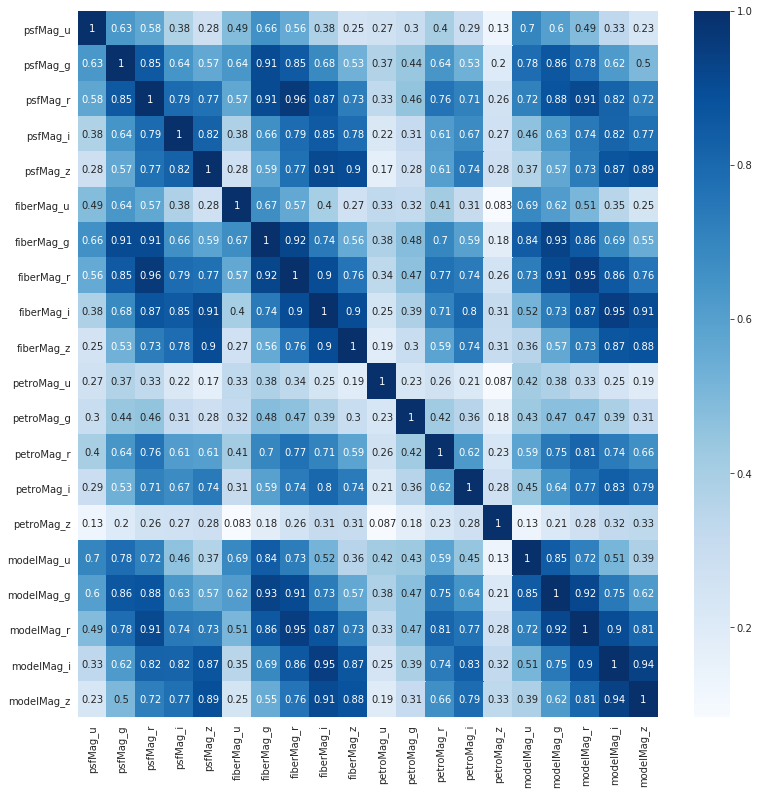

In [41]:
corrmat = set_data[sc_col].corr()
plt.figure(figsize=(13,13))
g = sns.heatmap(corrmat,annot=True,cmap="Blues")

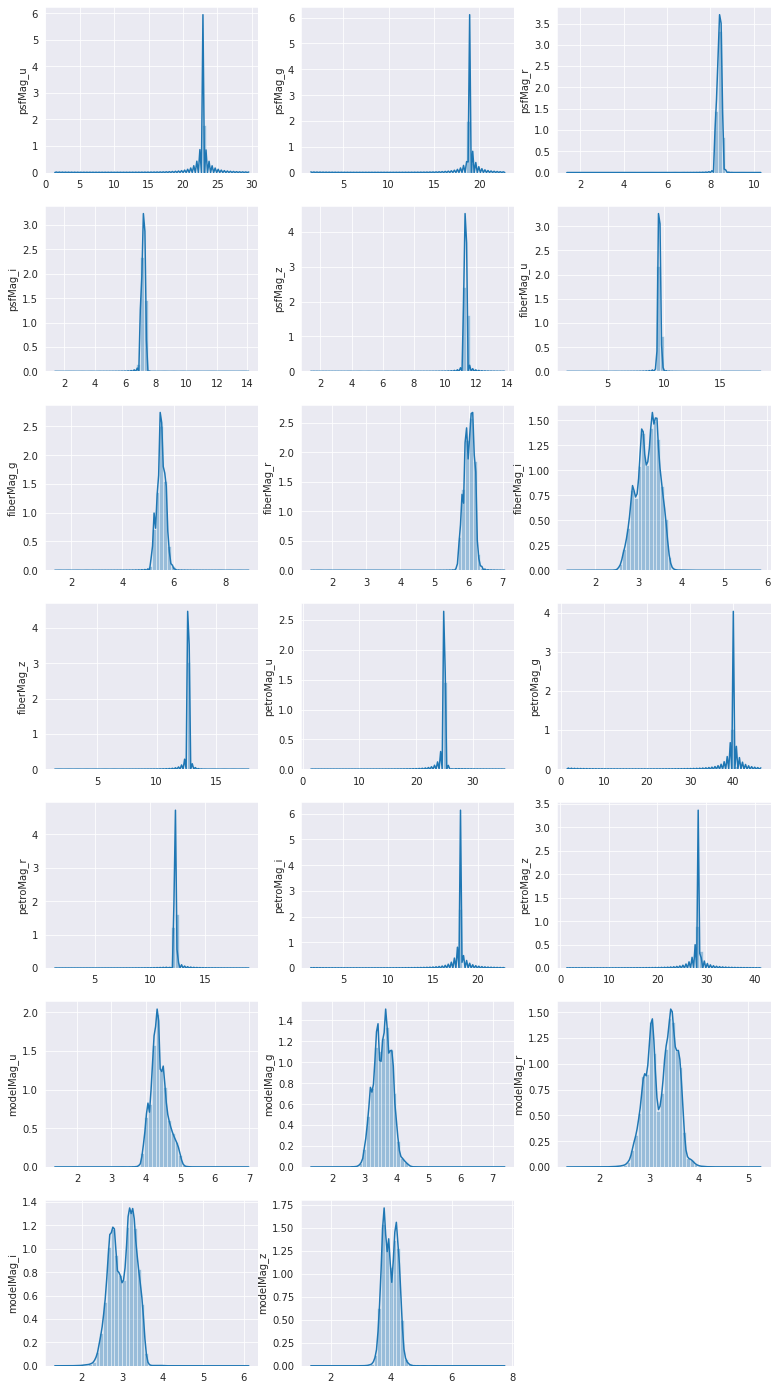

In [38]:
sns.set_style("darkgrid")
plt.figure(figsize=(13,25))
for i, col in enumerate(sc_col):
    plt.subplot(7,3,i+1)
    sns.distplot(set_data.iloc[:,i])
    plt.title("")
    plt.xlabel("")
    plt.ylabel(col)

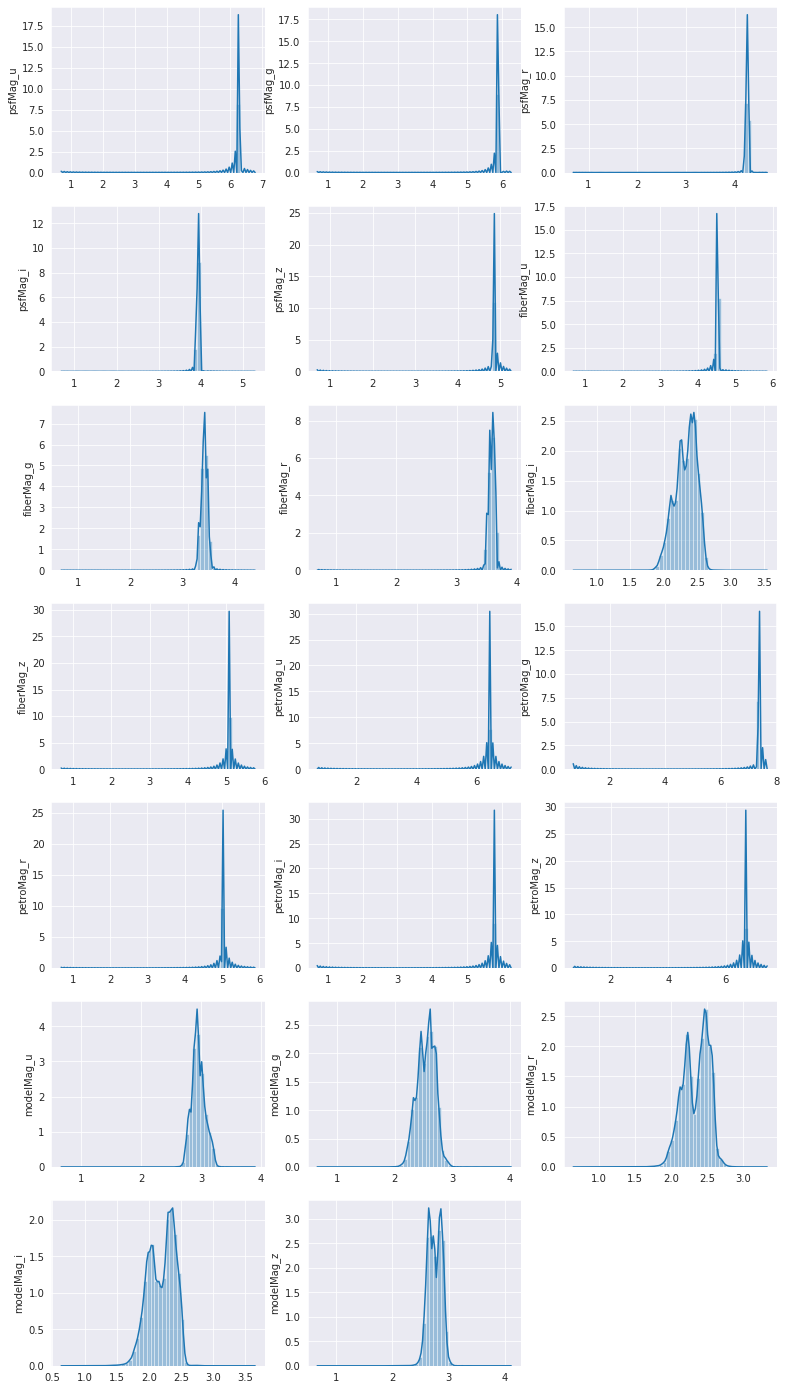

In [32]:
sns.set_style("darkgrid")
plt.figure(figsize=(13,25))
for i, col in enumerate(sc_col):
    plt.subplot(7,3,i+1)
    sns.distplot(set_data.iloc[:,i])
    plt.title("")
    plt.xlabel("")
    plt.ylabel(col)

psfMag_u  optimal lambda: 0.918374121097401
psfMag_g  optimal lambda: 1.1427139392002552
psfMag_r  optimal lambda: 0.9362482103729536
psfMag_i  optimal lambda: 0.28115193064639493
psfMag_z  optimal lambda: 1.2435451991490445
fiberMag_u  optimal lambda: 0.2774652343695296
fiberMag_g  optimal lambda: 0.41406958321131926
fiberMag_r  optimal lambda: 0.9105625027811284
fiberMag_i  optimal lambda: 0.533765146080059
fiberMag_z  optimal lambda: 0.657506275891819
petroMag_u  optimal lambda: 0.5426461508552254
petroMag_g  optimal lambda: 1.8455310399623148
petroMag_r  optimal lambda: 0.44949543664149133
petroMag_i  optimal lambda: 0.9343643367680448
petroMag_z  optimal lambda: 0.562435591172458
modelMag_u  optimal lambda: -0.19495177095014168
modelMag_g  optimal lambda: 0.2362400142287927
modelMag_r  optimal lambda: 0.43281191594820906
modelMag_i  optimal lambda: 0.4119669423996043
modelMag_z  optimal lambda: 0.13474915685672148


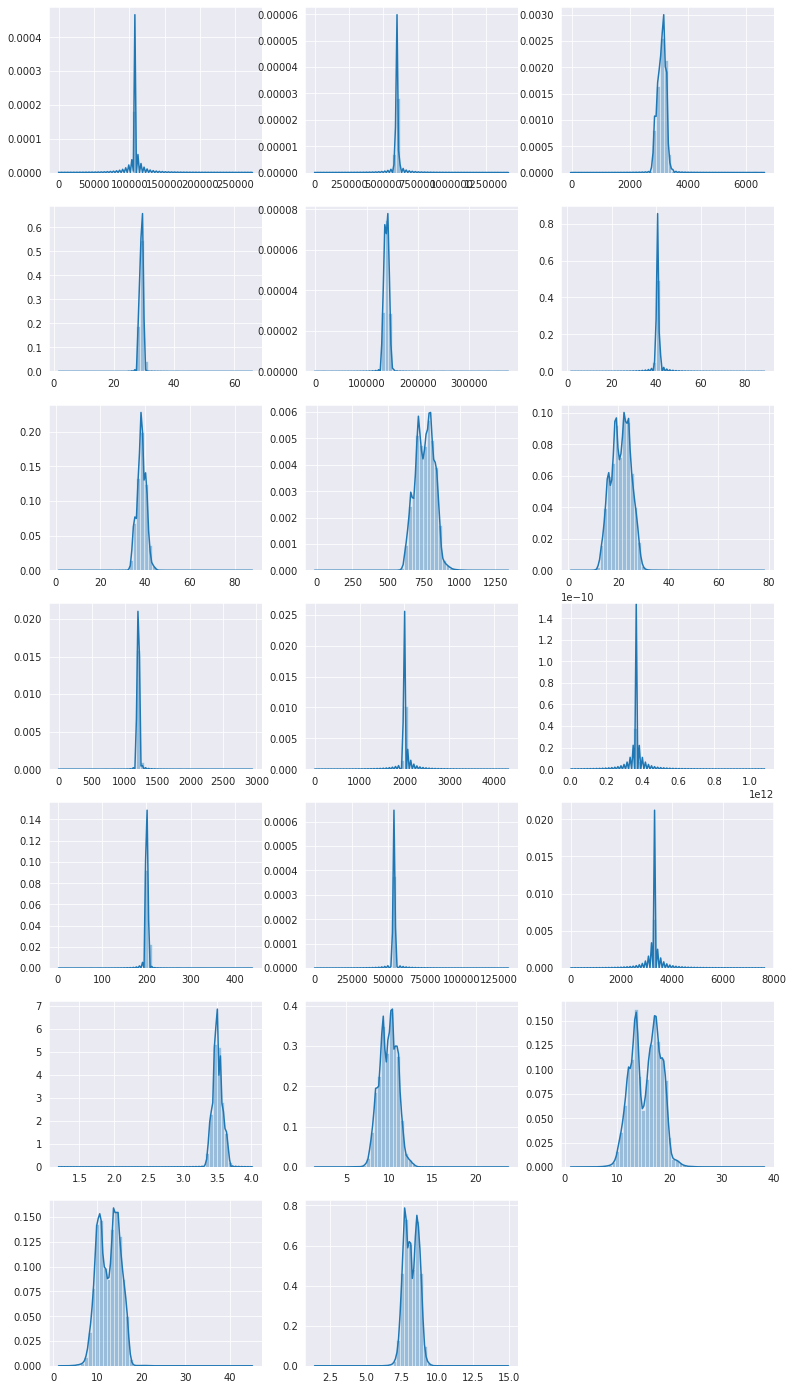

In [36]:
import scipy as sp
sns.set_style("darkgrid")
plt.figure(figsize=(13,25))
lambda_list = []
train_box = pd.DataFrame()
for i,col in enumerate(sc_col):
  ax1 = plt.subplot(7,3,i+1)
  #x, y = sp.stats.boxcox_normplot(train_x1.iloc[:,i], -2, 2)
  #plt.plot(x, y);
  y2, l = sp.stats.boxcox(set_data.iloc[:,i])
  train_box[col] = y2
  sns.distplot(y2, ax=ax1)
  #plt.axvline(x=l, color='r', ls="--");
  print(col ," optimal lambda:", l)
  lambda_list.append(l)

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
test_box = set_data.iloc[199953:,:]
train_box = set_data.iloc[:199953,:]
scaler =  StandardScaler()
scaler1 = MinMaxScaler()
train_x_sc = scaler.fit_transform(train_box)
test_x_sc = scaler.transform(test_box)
# train_not_sc = scaler1.fit_transform(train_x[not_col])
# test_not_sc = scaler1.transform(test_x[not_col])
train_x_sc =  pd.DataFrame(train_x_sc,columns = train_box.columns,index = train_box.index)
test_x_sc =  pd.DataFrame(test_x_sc,columns = test_box.columns,index = test_box.index)
# train_not_sc =  pd.DataFrame(train_not_sc,columns = sample_submission.columns,index = train_box.index)
# test_not_sc =  pd.DataFrame(test_not_sc,columns = sample_submission.columns,index = test_box.index)

In [0]:
train_x_sc = pd.concat([train_x_sc, train_not_sc],axis=1)
test_x_sc = pd.concat([test_x_sc, test_not_sc],axis=1)

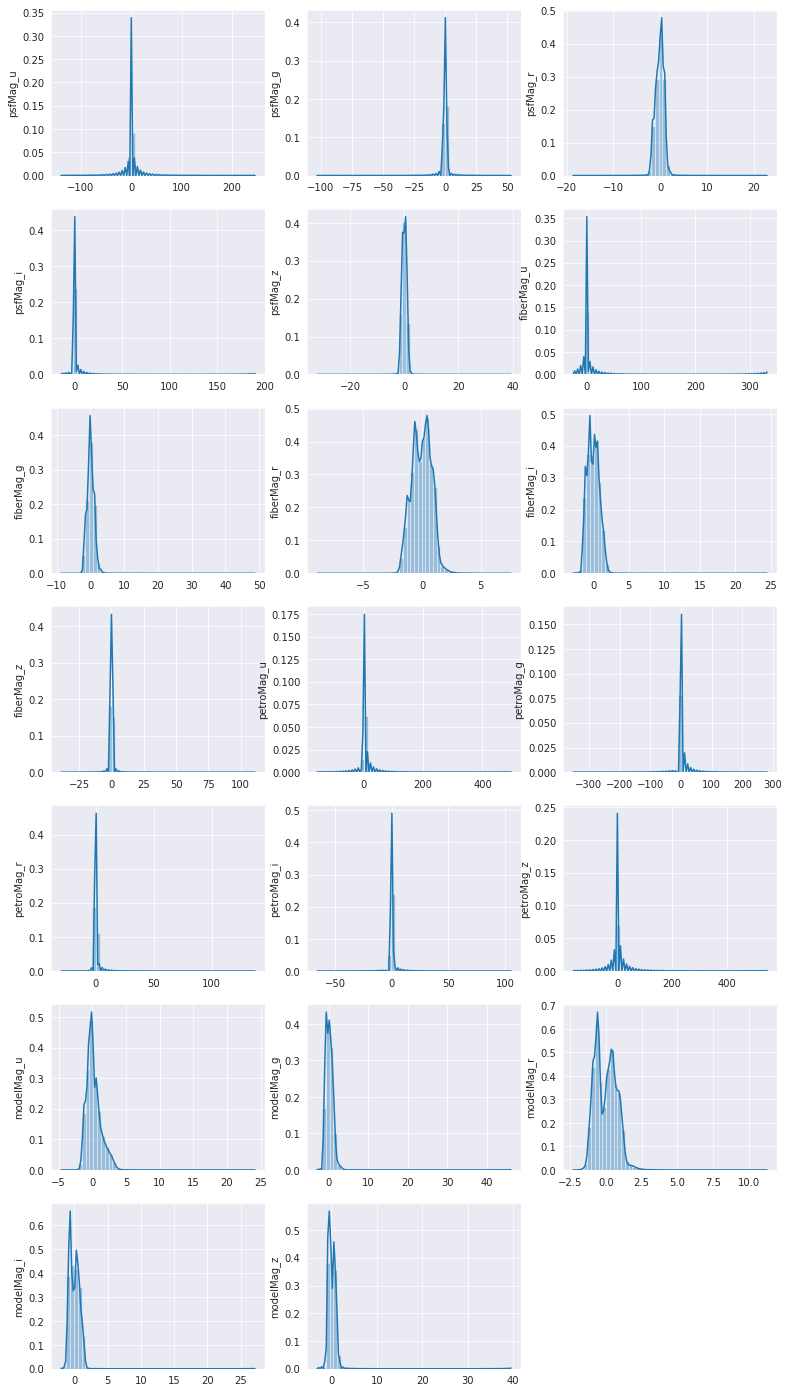

In [54]:
sns.set_style("darkgrid")
plt.figure(figsize=(13,25))
for i, col in enumerate(sc_col):
    plt.subplot(7,3,i+1)
    sns.distplot(train_x_sc.iloc[:,i])
    plt.title("")
    plt.xlabel("")
    plt.ylabel(col)

In [10]:
import tensorflow as tf
%tensorflow_version 2.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Model
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import callbacks
class mish(Activation):
    def __init__(self, activation, **kwargs):
        super(mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'

def Mish(x):
    return x*K.tanh(K.softplus(x))

get_custom_objects().update({'mish': mish(Mish)}) 

In [0]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
)

In [0]:

class LRFinder(Callback):
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        self.total_iterations = steps_per_epoch * epochs
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
epochs = 10
batch_size = 400
epoch_size = len(train_x)
lr_finder = LRFinder(min_lr=7e-6, 
                     max_lr=3e-3, 
                     steps_per_epoch=np.ceil(epoch_size/batch_size), 
                     epochs=epochs)


In [61]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
X_samp, y_samp = SMOTETomek(random_state=0, smote=SMOTE(sampling_strategy='auto', ratio={2:500, 17:100, 12:30}), 
                            tomek=TomekLinks(sampling_strategy='auto', ratio = {0:39500,6:27800,2:17200})).fit_sample(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

In [0]:
import lightgbm as lgb
lgb_clf1 = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=60, max_depth=-1, learning_rate=0.002, 
                             n_estimators=5000, subsample_for_bin=400000, objective='multiclass', min_split_gain=0.1,
                             min_child_weight=5e-3, min_child_samples=12,n_jobs=-1, random_state=42)
lgb_model1 = lgb_clf1.fit(x_train,y_train, eval_set = (x_val,y_val), early_stopping_rounds=50, verbose=100)

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's multi_logloss: 1.74445
[200]	valid_0's multi_logloss: 1.444
[300]	valid_0's multi_logloss: 1.23729
[400]	valid_0's multi_logloss: 1.08363
[500]	valid_0's multi_logloss: 0.965084
[600]	valid_0's multi_logloss: 0.871682
[700]	valid_0's multi_logloss: 0.796644
[800]	valid_0's multi_logloss: 0.735887
[900]	valid_0's multi_logloss: 0.686077
[1000]	valid_0's multi_logloss: 0.64501
[1100]	valid_0's multi_logloss: 0.61115
[1200]	valid_0's multi_logloss: 0.583149
[1300]	valid_0's multi_logloss: 0.559792
[1400]	valid_0's multi_logloss: 0.540105
[1500]	valid_0's multi_logloss: 0.523598
[1600]	valid_0's multi_logloss: 0.509565
[1700]	valid_0's multi_logloss: 0.497629
[1800]	valid_0's multi_logloss: 0.487449
[1900]	valid_0's multi_logloss: 0.47873
[2000]	valid_0's multi_logloss: 0.471088
[2100]	valid_0's multi_logloss: 0.464495
[2200]	valid_0's multi_logloss: 0.458841
[2300]	valid_0's multi_logloss: 0.453865
[2400]	valid_

In [0]:
lgb_model1.learning_rate= 0.001
lgb_model1.min_child_samples=5
lgb_model1.n_estimators = 1000
lgb_model1.fit(x_train,y_train, eval_set = (x_val,y_val), early_stopping_rounds=50, verbose=100)

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's multi_logloss: 1.96461
[200]	valid_0's multi_logloss: 1.7457
[300]	valid_0's multi_logloss: 1.57942
[400]	valid_0's multi_logloss: 1.4453
[500]	valid_0's multi_logloss: 1.33348
[600]	valid_0's multi_logloss: 1.23861
[700]	valid_0's multi_logloss: 1.15663
[800]	valid_0's multi_logloss: 1.0849
[900]	valid_0's multi_logloss: 1.02199
[1000]	valid_0's multi_logloss: 0.966375
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 0.966375


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.001, max_depth=-1,
               min_child_samples=5, min_child_weight=0.005, min_split_gain=0.1,
               n_estimators=1000, n_jobs=-1, num_leaves=60,
               objective='multiclass', random_state=42, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=400000, subsample_freq=0)

In [0]:
rep_x = np.append(norm_hid_rep[:1000,:], fraud_hid_rep[:1000,:], axis = 0)
y_n = np.zeros(1000)
y_f = np.ones(1000)
rep_y = np.append(y_n, y_f)

No handles with labels found to put in legend.


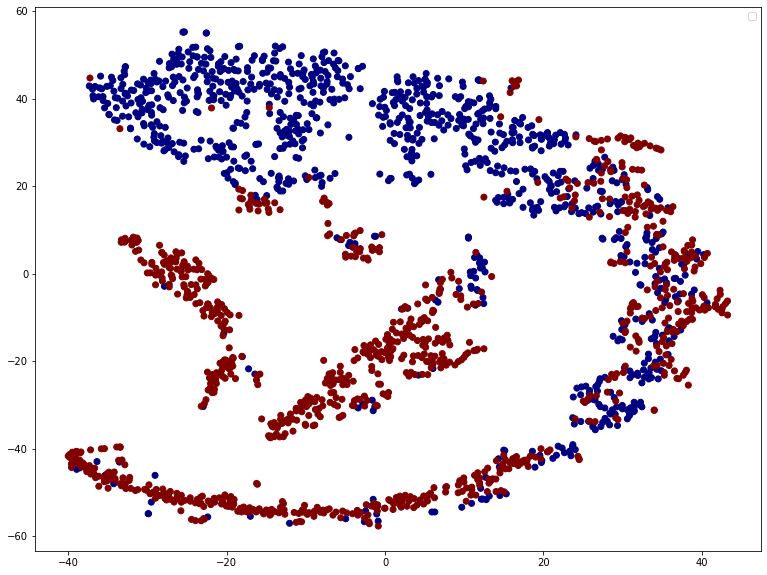

In [0]:

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(rep_x)
plt.figure(figsize=(13,10))
plot_digits()
plt.legend(loc="best")

In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
pca = PCA()
x_train_pc = pca.fit_transform(train_x)
X = train_x_sc[3000:,:]
y = train_y[3000:]
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

In [0]:
x_train.shape

(159955, 20)

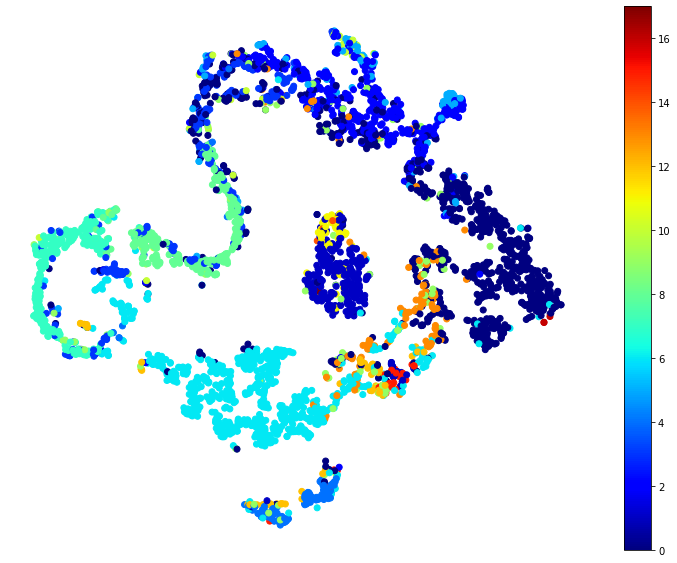

In [0]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet",)
plt.axis('off')
plt.colorbar()

In [14]:
def res_unit(inputs, channels):
    x = BatchNormalization()(inputs)
    x = Activation('relu')(x)
    x = Conv1D(channels, kernel_size=3, padding='same', use_bias=False)(x)
    x = Activation('relu')(x)
    x = Conv1D(channels, kernel_size=3, padding='same', use_bias=False)(x)
    added = Add()([inputs, x])
    return added

def res_unit_stride(inputs, channels,pad='same'):
    x = BatchNormalization()(inputs)
    x = Activation('relu')(x)
    x = Conv1D(channels, kernel_size=3, strides=2, padding=pad, use_bias=False)(x)
    x = Activation('relu')(x)
    x = Conv1D(channels, kernel_size=3, padding=pad, use_bias=False)(x)
    conv = Conv1D(channels, kernel_size=1, strides=2, padding=pad, use_bias=False)(inputs)
    added = Add()([conv, x])
    return added

seq_in = Input(shape=(60,1))
x = Conv1D(16, kernel_size=3, activation='mish', padding='same')(seq_in)
x =  res_unit(x, 16)
x =  res_unit(x, 16)
x =  res_unit(x, 16)
x =  res_unit_stride(x, 32)
x =  res_unit(x, 32)
x =  res_unit(x, 32)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv1D(32, kernel_size=3, padding='valid', use_bias=False)(x)
x =  res_unit(x, 32)
x =  res_unit_stride(x, 64)
x =  res_unit(x, 64)
x =  res_unit(x, 64)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv1D(64, kernel_size=3, padding='valid', use_bias=False)(x)
x =  res_unit(x, 64)
x =  res_unit_stride(x, 128)
x =  res_unit(x, 128)
x =  res_unit(x, 128)
x =  res_unit(x, 128)
x =  res_unit(x, 128)
x =  res_unit_stride(x, 256)
x =  res_unit(x, 256)
x =  res_unit(x, 256)
x =  res_unit(x, 256)
x =  res_unit(x, 256)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = GlobalAveragePooling1D()(x)
x = Dense(256, kernel_initializer='he_normal', activation='relu')(x)
seq = Dense(60 , activation='linear')(x)
# seq_out = Dense(19, kernel_initializer='he_normal', activation='softmax')(x)
seq_out = Reshape((60,1))(seq)
res_model = Model(inputs=seq_in , outputs=seq_out)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [56]:
res_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_284 (Conv1D)             (None, 60, 16)       64          input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_138 (BatchN (None, 60, 16)       64          conv1d_284[0][0]                 
__________________________________________________________________________________________________
activation_260 (Activation)     (None, 60, 16)       0           batch_normalization_138[0][0]    
____________________________________________________________________________________________

In [0]:
optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.001)
res_model.compile(optimizer=optimizer1,
              loss='mse',
              metrics=['mse'])
ckpt_dir = '/gdrive/My Drive/ckpt'
ckpt_path = ckpt_dir + '/encoder3_{epoch:02d}_loss{loss:.2f}.hdf5'
ckpt = callbacks.ModelCheckpoint(ckpt_path, monitor='loss', verbose=0, 

                                 save_best_only=True, mode='min')

In [0]:
_data = pd.concat([train_x_sc,test_x_sc],axis=0)
x_train1 = np.expand_dims(_data, axis=2)
epochs = 30
batch_size = 1024
epoch_size = len(set_data)
lr_finder = LRFinder(min_lr=1e-5, 
                     max_lr=1e-3, 
                     steps_per_epoch=np.ceil(epoch_size/batch_size), 
                     epochs=epochs)


In [110]:
res_model.fit(x_train1,x_train1,batch_size=768,callbacks=[ckpt,lr_finder],shuffle=True,epochs=30)

Train on 209962 samples
Epoch 1/30
209962/209962 [==============================] - 24s 116us/sample - loss: 0.1571 - mean_squared_error: 0.1571
Epoch 2/30
209962/209962 [==============================] - 25s 119us/sample - loss: 0.0571 - mean_squared_error: 0.0571
Epoch 3/30
209962/209962 [==============================] - 25s 119us/sample - loss: 0.0430 - mean_squared_error: 0.0430
Epoch 4/30
209962/209962 [==============================] - 24s 116us/sample - loss: 0.0437 - mean_squared_error: 0.0437
Epoch 5/30
209962/209962 [==============================] - 25s 118us/sample - loss: 0.0673 - mean_squared_error: 0.0673
Epoch 6/30
209962/209962 [==============================] - 26s 126us/sample - loss: 0.0747 - mean_squared_error: 0.0747
Epoch 7/30
209962/209962 [==============================] - 27s 128us/sample - loss: 0.0431 - mean_squared_error: 0.0431
Epoch 8/30
209962/209962 [==============================] - 27s 128us/sample - loss: 0.0388 - mean_squared_error: 0.0388
Epoch 9/

In [45]:
# res_model.load_weights('/gdrive/My Drive/ckpt/encoder3_07_loss0.01.hdf5')
res_model.fit(x_train1,x_train1,batch_size=1024,callbacks=[ckpt,lr_finder],shuffle=True,epochs=10)

Train on 209962 samples
Epoch 1/10
 60416/209962 [=======>......................] - ETA: 34s - loss: 0.0063 - mean_squared_error: 0.0063

KeyboardInterrupt: ignored

In [0]:
res_model.load_weights('/gdrive/My Drive/ckpt/encoder3_08_loss0.01.hdf5')


In [0]:
new_set = res_model.predict(x_train1)
ntrain_x = new_set[:199953,:]
ntest_x = new_set[199953:,:]
ntrain_x = np.squeeze(ntrain_x,axis=2)

In [0]:
type(ntrain_x)

numpy.ndarray

In [0]:
outs =  Dense(64,activation='relu')(x)
outputs =  Dense(19,activation='softmax')(outs)
new_model = Model(inputs=seq_in, outputs=outputs)

In [0]:
new_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy',metrics=['accuracy'])
ckpt_path = ckpt_dir + '/modeling2_{epoch:02d}_valloss{val_loss:.2f}.hdf5'
ckpt = callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

In [141]:
new_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_431 (Conv1D)             (None, 60, 16)       64          input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_210 (BatchN (None, 60, 16)       64          conv1d_431[0][0]                 
__________________________________________________________________________________________________
activation_395 (Activation)     (None, 60, 16)       0           batch_normalization_210[0][0]    
___________________________________________________________________________________________

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(test_size=0.1, random_state=0)

for train_index, test_index in split.split(ntrain_x, train_y):
    x_train, y_train = ntrain_x[train_index,:], train_y[train_index]
    x_val, y_val = ntrain_x[test_index,:] , train_y[test_index]

In [66]:
train_y.value_counts()

8     49677
6     37333
18    21756
15    14629
4     14616
10    13749
5     13494
13     7132
11     6575
1      6506
7      4653
14     3257
3      2561
0      2160
16     1154
2       500
9       127
17       61
12       13
Name: type_num, dtype: int64

In [67]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
X_samp, y_samp = SMOTETomek(random_state=0, smote=SMOTE(sampling_strategy='auto', ratio={16:1400,2:700, 17:120, 12:40}), 
                            tomek=TomekLinks(sampling_strategy='auto', ratio = {0:48000,6:33000,2:20000})).fit_sample(ntrain_x, train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [79]:
epochs = 10
batch_size = 2048
epoch_size = len(ntrain_x)
lr_finder = LRFinder(min_lr=1e-5, 
                     max_lr=1e-3, 
                     steps_per_epoch=np.ceil(epoch_size/batch_size), 
                     epochs=epochs)

new_model.fit(np.expand_dims(X_samp,axis=2),y_samp ,batch_size=2048,callbacks=[ckpt, lr_finder,early_stop],shuffle=True, validation_split=0.15,epochs=100)

Train on 169380 samples, validate on 29891 samples
Epoch 1/100
169380/169380 [==============================] - 39s 230us/sample - loss: 0.3508 - acc: 0.8780 - val_loss: 0.3954 - val_acc: 0.8588
Epoch 2/100
169380/169380 [==============================] - 40s 235us/sample - loss: 0.3452 - acc: 0.8795 - val_loss: 0.3724 - val_acc: 0.8672
Epoch 3/100
169380/169380 [==============================] - 39s 233us/sample - loss: 0.3494 - acc: 0.8782 - val_loss: 0.4129 - val_acc: 0.8567
Epoch 4/100
 68608/169380 [===========>..................] - ETA: 22s - loss: 0.3422 - acc: 0.8794

KeyboardInterrupt: ignored

In [64]:

epochs = 100
batch_size = 256
epoch_size = len(ntrain_x)
lr_finder = LRFinder(min_lr=1e-5, 
                     max_lr=1e-3, 
                     steps_per_epoch=np.ceil(epoch_size/batch_size), 
                     epochs=epochs)
early_stop = callbacks.EarlyStopping(patience=10, monitor='val_loss')
new_model.fit(np.expand_dims(X_samp,axis=2),y_samp ,batch_size=256,callbacks=[lr_finder,early_stop],shuffle=True, validation_split=0.15,epochs=100)

Train on 152172 samples, validate on 26854 samples
Epoch 1/100
152172/152172 [==============================] - 55s 360us/sample - loss: 0.3448 - acc: 0.8782 - val_loss: 0.3571 - val_acc: 0.8752
Epoch 2/100
152172/152172 [==============================] - 53s 348us/sample - loss: 0.3413 - acc: 0.8792 - val_loss: 0.3488 - val_acc: 0.8772
Epoch 3/100
152172/152172 [==============================] - 53s 347us/sample - loss: 0.3403 - acc: 0.8799 - val_loss: 0.3605 - val_acc: 0.8748
Epoch 4/100
 27904/152172 [====>.........................] - ETA: 42s - loss: 0.3456 - acc: 0.8772

KeyboardInterrupt: ignored

In [0]:
# optimizer = tf.keras.optimizers.Adam(amsgrad=True,
#     learning_rate=0.0005,
# )

new_model.load_weights('/gdrive/My Drive/ckpt/modeling2_02_valloss0.37.hdf5')
pred_mat = new_model.predict_on_batch(ntest_x)

# ckpt_path = ckpt_dir + '/modeling3_{epoch:02d}_valloss{val_loss:.2f}.hdf5'
# ckpt = callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
# early_stop = callbacks.EarlyStopping(patience=40, monitor='val_loss')

# epochs = 50
# batch_size = 256*3
# epoch_size = len(ntrain_x)
# lr_finder = LRFinder(min_lr=1e-5, 
#                      max_lr=2e-3, 
#                      steps_per_epoch=np.ceil(epoch_size/batch_size), 
#                      epochs=epochs)
# new_model.fit(ntrain_x,train_y,batch_size=256*3,callbacks=[ckpt, lr_finder,early_stop],shuffle=True, validation_split=0.25,epochs=50)

In [0]:
pred_mat1 = new_model.predict_on_batch(ntest_x)

In [81]:
pred_mat


array([[2.8998056e-05, 8.2690378e-05, 1.0170814e-03, ..., 1.6406567e-04,
        6.2162266e-04, 2.3874397e-04],
       [8.4997700e-06, 6.2364796e-07, 2.4399394e-06, ..., 1.2664040e-07,
        3.0857893e-05, 3.6295819e-06],
       [7.4637668e-05, 1.9345787e-06, 4.8738520e-06, ..., 4.5163581e-08,
        1.4237784e-07, 4.4154982e-05],
       ...,
       [4.5307943e-06, 2.5697229e-05, 1.6717529e-06, ..., 2.3731830e-07,
        1.7577700e-05, 1.7661718e-03],
       [2.9041277e-07, 3.9979486e-06, 4.3909981e-07, ..., 1.3704756e-08,
        2.3559503e-06, 1.9650716e-04],
       [7.2466592e-06, 4.3641103e-05, 3.7344678e-06, ..., 3.7393335e-07,
        2.4944136e-05, 9.4116380e-04]], dtype=float32)

In [85]:

submission = pd.DataFrame(pred_mat1)
submission['id'] = np.arange(199991,210000,1)
submission.set_index('id',inplace=True)
submission = submission.rename(columns=i2lb)
submission = submission[sample_submission.columns]
submission.to_csv("/gdrive/My Drive/Data/submission4.csv")
submission

,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
id,,,,,,,,,,,,,,,,,,,
199991,2.240548e-08,1.284881e-07,1.101976e-01,0.046835,0.225928,3.580385e-08,4.117289e-01,5.074892e-05,4.921634e-05,9.275993e-07,9.754897e-05,1.323932e-13,1.192348e-06,1.767920e-01,2.903634e-07,1.975543e-06,2.053135e-06,0.028314,7.440781e-10
199992,1.644026e-13,3.373008e-06,2.733495e-09,0.209783,0.030791,2.044425e-09,1.142082e-09,1.135178e-03,6.561931e-01,2.811740e-17,1.335706e-11,3.358010e-22,1.004653e-01,7.859048e-11,9.896895e-09,1.596833e-03,1.220398e-09,0.000032,1.338158e-20
199993,6.490978e-10,2.363472e-04,5.052442e-06,0.732062,0.001413,6.836043e-10,1.900787e-05,6.578983e-04,2.637998e-01,1.080004e-12,2.404204e-06,2.126420e-15,6.836214e-06,3.059597e-07,2.871918e-09,1.358030e-03,3.042820e-06,0.000436,7.325950e-14
199994,1.567248e-12,1.588390e-07,3.532086e-05,0.209403,0.003915,4.127972e-10,2.252146e-04,6.778679e-07,7.196083e-01,1.838262e-14,5.458433e-09,2.079456e-20,7.965662e-07,4.728138e-08,3.398185e-08,2.891158e-07,1.896819e-08,0.066812,7.184152e-16
199995,3.648304e-07,3.871428e-06,3.799772e-02,0.748160,0.078420,1.262641e-05,2.372275e-03,3.601429e-03,9.439971e-02,6.134108e-08,1.994800e-05,3.062063e-10,7.813187e-03,8.576591e-04,2.157050e-04,1.837012e-04,4.296165e-06,0.025937,2.294483e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209995,8.443152e-05,9.711296e-08,1.543223e-06,0.406637,0.000469,2.073935e-05,1.019962e-02,6.904323e-05,3.422414e-07,5.761347e-06,2.197093e-06,8.105296e-12,7.311978e-02,5.081354e-01,1.637333e-04,9.052070e-06,3.995587e-09,0.001082,3.384123e-09
209996,1.666970e-06,2.461746e-07,2.818092e-05,0.305446,0.230357,8.838241e-06,1.364346e-04,3.194616e-04,2.864199e-04,1.381321e-08,2.304917e-07,1.488447e-13,4.618664e-01,4.845285e-04,5.574948e-04,3.753545e-06,2.085086e-08,0.000503,5.143020e-11
209997,8.476508e-06,5.093063e-07,3.749449e-07,0.089524,0.000089,7.079412e-07,3.526218e-01,7.452128e-05,9.028287e-07,3.586009e-07,8.104922e-07,1.145529e-12,2.693171e-03,5.532789e-01,7.025735e-05,1.725046e-06,7.106300e-09,0.001634,7.784802e-10


In [28]:
lr_finder.plot_loss()

KeyError: ignored